In [1]:
%matplotlib inline

import numpy as np
import pylab as plt

In [2]:
import healpy as hp

# Load Haslam map (Remazeilles et al. 2015)
haslam_408 = hp.read_map("haslam408_dsds_Remazeilles2014_ns2048.fits")
nside = hp.get_nside(haslam_408)  
print(nside)

2048


In [3]:
from pygdsm import GlobalSkyModel16
from pygdsm import GlobalSkyModel
from pygdsm import LowFrequencySkyModel
from pygdsm import HaslamSkyModel

# Using Global Sky Model 2016

In [4]:
gsm2016 = GlobalSkyModel16(freq_unit='MHz')
# gsm16_408 = gsm2016.generate(408)
# gsm16_220 = gsm2016.generate(220)

gsm16_2600 = gsm2016.generate(2600)
gsm16_1400 = gsm2016.generate(1400)

In [5]:
gsm16_2600 = hp.ud_grade(gsm16_2600, nside)
gsm16_1400 = hp.ud_grade(gsm16_1400, nside)

In [6]:
alpha_gsm16 = -np.log(gsm16_2600 / gsm16_1400) / np.log(2600 / 1400)

/tmp/ipykernel_3375/3180174096.py:1: RuntimeWarning: invalid value encountered in log
  alpha_gsm16 = -np.log(gsm16_2600 / gsm16_1400) / np.log(2600 / 1400)


In [7]:
with np.errstate(divide='ignore', invalid='ignore'):
    ratio = gsm16_2600 / gsm16_1400
    alpha_gsm16 = -np.log(ratio) / np.log(2600 / 1400)

# Step 1: Identify invalid pixels
invalid_mask = ~np.isfinite(alpha_gsm16) | (gsm16_2600 <= 0) | (gsm16_1400 <= 0)

# Step 2: Replace or mask invalid values
alpha_gsm16[invalid_mask] = np.nan  # or a default like alpha.mean()

In [8]:
haslam_220_gsm16 = haslam_408 * (220 / 408)**(-alpha_gsm16)

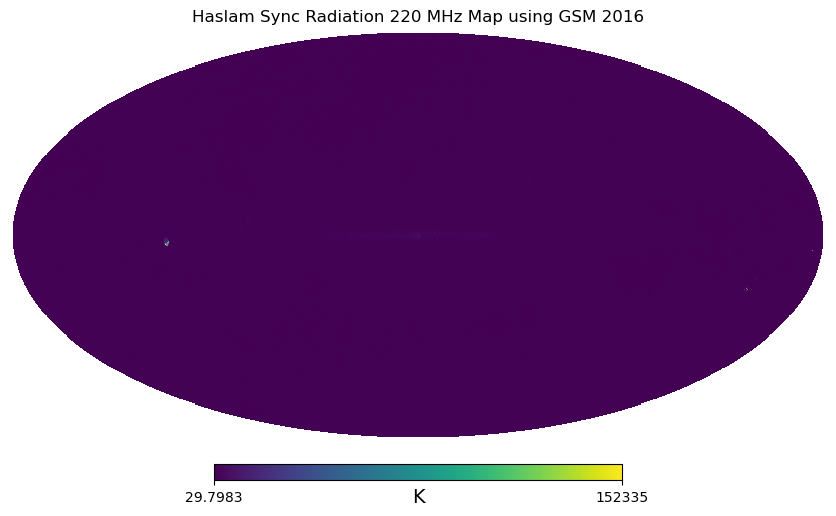

In [9]:
hp.mollview(haslam_220_gsm16, title='Haslam Sync Radiation 220 MHz Map using GSM 2016', unit='K')
plt.show()

## Extract & Plot a Rectangular Region (Galactic Coordinates)

In [96]:
# l_min, l_max = -32.25, -21.75     # Dec range in degrees
# b_min, b_max = -5.25, 5.25    # RA range in degrees

# # Make grid of lon/lat
# lon = np.linspace(l_min, l_max, 1000)
# lat = np.linspace(b_min, b_max, 500)
# lon_grid, lat_grid = np.meshgrid(lon, lat)

# # Convert to HEALPix angles (theta = 90 - lat)
# theta = np.radians(90 - lat_grid)
# phi = np.radians(lon_grid)

# # Get pixel indices
# pix_indices = hp.ang2pix(nside, theta, phi)

# # Extract map values at those pixels
# map_values = haslam_220_gsm16[pix_indices]
# map_values = map_values.reshape(lat_grid.shape)

In [105]:
# # Plot the rectangular patch

# plt.imshow(map_values, origin="lower", extent=[b_min, b_max, l_min, l_max], aspect='auto', cmap='inferno')
# plt.colorbar(label="Brightness Temperature [K]")
# plt.xlabel("RA (deg)")
# plt.ylabel("Dec (deg)")
# plt.title("Rectangular Patch of Haslam 220 MHz Map")
# plt.show()

## Another method

In [98]:
from astropy.wcs import WCS
from reproject import reproject_from_healpix
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np

# Define your region (10.5 deg x 10.5 deg) around center (e.g., RA=0, Dec=-27)
size = 10.5  # degrees
pixel_size = 21 / 60  # arcsec to arcmin
npix = int(size * 60 / pixel_size)  # image pixels per side

wcs = WCS(naxis=2)
wcs.wcs.crpix = [npix/2, npix/2]
wcs.wcs.cdelt = np.array([-pixel_size/60, pixel_size/60])  # deg/pix
wcs.wcs.crval = [0, -27]  # center RA, Dec in degrees
wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]

shape_out = (npix, npix)
haslam_220_gsm16_rect, _ = reproject_from_healpix((haslam_220_gsm16, "galactic"), wcs, shape_out=shape_out, nested = False)

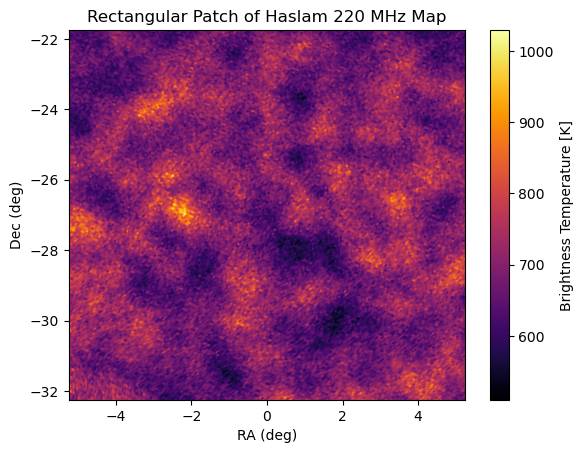

In [103]:
plt.imshow(haslam_220_gsm16_rect, origin="lower", extent=[wcs.wcs.crval[0]-size/2, wcs.wcs.crval[0]+size/2, wcs.wcs.crval[1]-size/2, wcs.wcs.crval[1]+size/2], aspect='auto', cmap='inferno')
plt.colorbar(label="Brightness Temperature [K]")
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.title("Rectangular Patch of Haslam 220 MHz Map")
plt.show()

In [100]:
from scipy.ndimage import gaussian_filter

fwhm_arcmin = 1.75
pixel_scale_arcmin = 21 / 60  # arcsec to arcmin
sigma = fwhm_arcmin / (2.355 * pixel_scale_arcmin)

haslam_220_gsm16_gf = gaussian_filter(haslam_220_gsm16_rect, sigma=sigma)

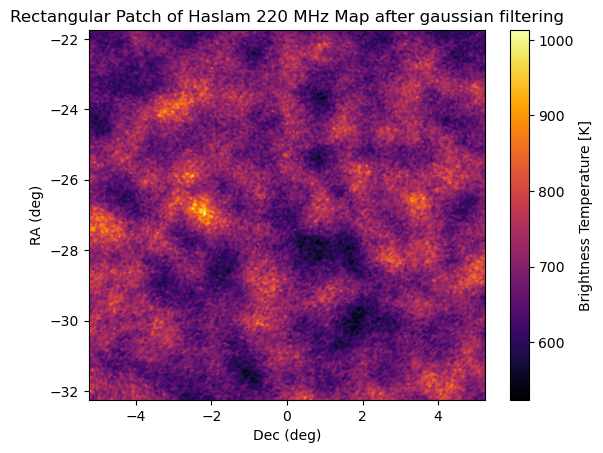

In [104]:
plt.imshow(haslam_220_gsm16_gf, origin="lower", extent=[wcs.wcs.crval[0]-size/2, wcs.wcs.crval[0]+size/2, wcs.wcs.crval[1]-size/2, wcs.wcs.crval[1]+size/2], aspect='auto', cmap='inferno')
plt.colorbar(label="Brightness Temperature [K]")
plt.xlabel("Dec (deg)")
plt.ylabel("RA (deg)")
plt.title("Rectangular Patch of Haslam 220 MHz Map after gaussian filtering")
plt.show()